<!-- dom:TITLE: Programmation Python  pour les mathématiques -->
# Numerical methods for time-dependent PDE
## TP2 - Transport equation with variable coefficients
<!-- dom:AUTHOR: Julien Guillod at [Sorbonne Université](http://www.sorbonne-universite.fr/), -->
<!-- Author: -->
**Julien Guillod**, [Sorbonne Université](http://www.sorbonne-universite.fr/),
Licence <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">CC BY-NC-ND</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Characteristics

In [2]:
def plot_char(a, label, x=np.linspace(-1,1,51), t=np.linspace(0,1,100)):
    sol = solve_ivp(a, [t[0],t[-1]], x, t_eval=t)
    fig = plt.figure(figsize=(16,5))
    fig.suptitle(f'Characteristics for $a(x)={label}$')
    sub = fig.add_subplot(1,2,1)
    sub.set_xlabel("$x$")
    sub.set_ylabel("$t$")
    for i in range(len(x)):
        sub.plot(sol.y[i],sol.t, 'b')
    sub =  fig.add_subplot(1,2,2)
    sub.set_xlabel("$x$")
    sub.set_ylabel("$a(x)$")
    xx = np.linspace(-1,1,1000)
    sub.plot(xx,a(0,xx))

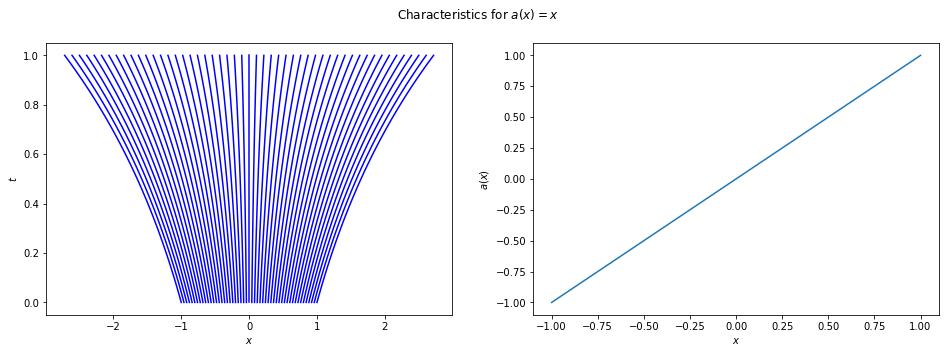

In [3]:
plot_char(lambda t,x: x, r"x")

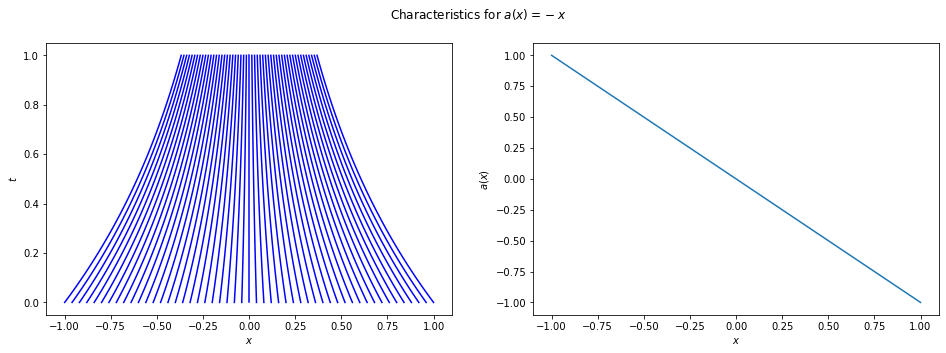

In [4]:
plot_char(lambda t,x: -x, r"-x")

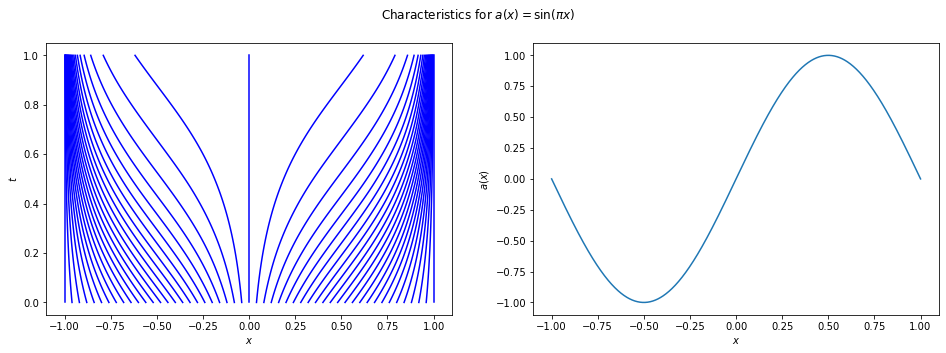

In [5]:
plot_char(lambda t,x: np.sin(np.pi*x), r"\sin(\pi x)")

For $a(x)=\sqrt{|x|}$, the solution starting at $x=0$ is not unique, there is $x(t)=0$, $x(t)=\frac{t^2}{4}$, and obviously all the translations. So the numerics is not complete nor correct near $x=0$:

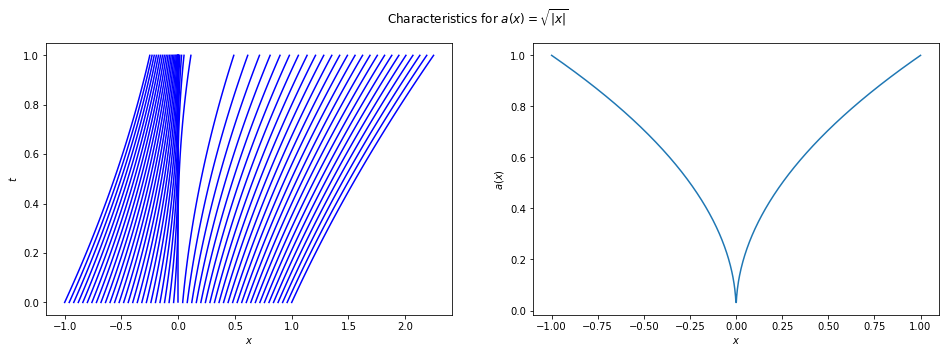

In [6]:
plot_char(lambda t,x: np.sqrt(np.fabs(x)), r"\sqrt{|x|}")

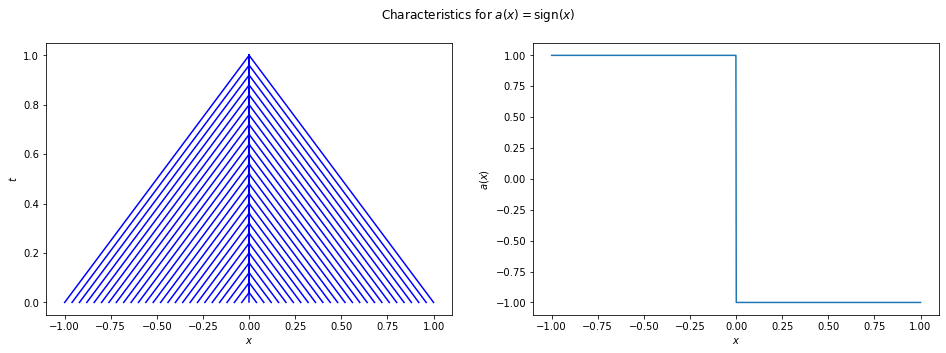

In [7]:
plot_char(lambda t,x: -np.sign(x), r"\mathrm{sign}(x)")

## Numerical schemes

In [8]:
# definition of the initial data
@np.vectorize
def u0(x):
    if -0.2 <= x <= 0.2:
        return 1.
    else:
        return 0.
# smooth version
def u0_smooth(x):
    return np.exp(-(x/0.2)**4)

In [9]:
# Class to initalize and run the problem
class simulate:
    
    def __init__(self):
        self.Nx = 100
        self.cfl = 0.3
        self.T = 0.3

    def update(self):
        self.x = np.linspace(-1, 1, self.Nx, endpoint=False) # space grid
        self.dx = self.x[1]-self.x[0] # spatial step
        self.dt = self.cfl*self.dx # time step
        self.t = np.arange(0,self.T,self.dt) # time grid

    def run(self):
        self.update()
        method = self.method
        # probes for L1/Linfty
        probes = []
        # discretization of a
        a = self.a(self.x)
        # time stepping
        for time in self.t:
            if time == 0:
                u = self.u0(self.x)
            else:
                u = method(u, a, self.cfl)
            if hasattr(self,'probe'):
                probes.append(self.probe(u))
        self.u = u
        self.probes = probes
        return u
    
    def norm_p(self,u,p):
        err = np.linalg.norm(u, p)
        if p != np.inf:
            err = err*self.dx**(1/p)
        return err
    
    def error(self):
        return self.norm_p(self.u - self.exact, self.norm)

### Non-conservative scheme

In [10]:
# Timestep for upwind non-conservative
def upwind1(u, a, CFL):
    du = np.zeros_like(u)
    ap = np.maximum(a,0)
    am = np.maximum(-a,0)
    du[1:-1] = am[1:-1]*(u[1:-1]-u[2:]) - ap[:-2]*(u[:-2]-u[1:-1])
    du[0] = am[0]*(u[0]-u[1]) - ap[-1]*(u[-1]-u[0])
    du[-1] = am[-1]*(u[-1]-u[0]) - ap[-2]*(u[-2]-u[-1])
    u -= CFL*du
    return u

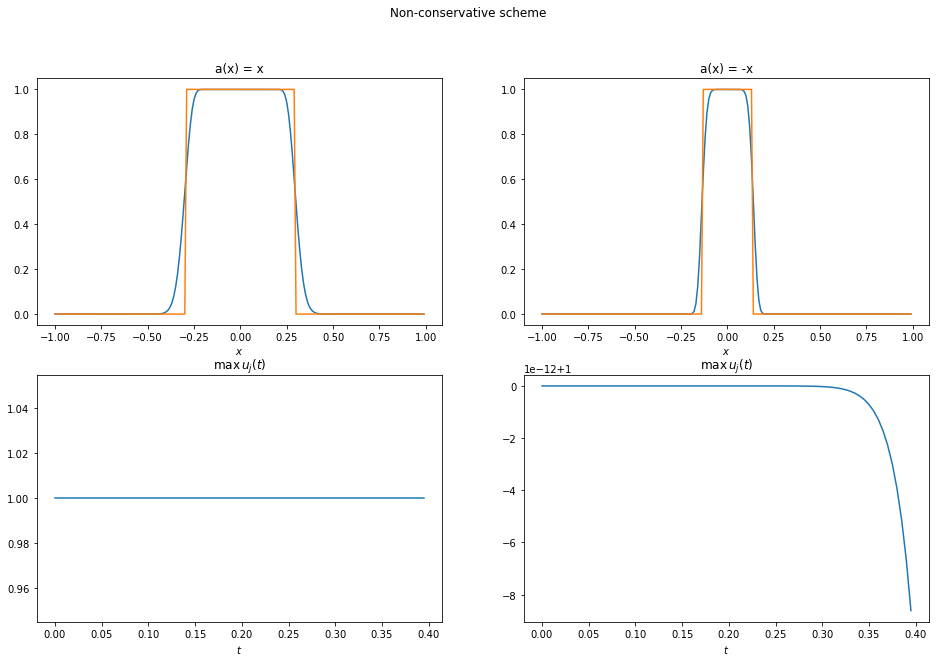

In [11]:
s = simulate()
s.Nx = 200
s.T = 0.4
s.cfl = 0.5
s.method = upwind1
s.probe = np.max
s.u0 = u0
# plot
fig = plt.figure(figsize=(16,10))
fig.suptitle(f'Non-conservative scheme')
# iterate for \pm
for k in (1,-1):
    s.a = lambda x:k*x
    s.run()
    s.exact = s.u0(np.exp(-k*s.t[-1])*s.x)
    sub = fig.add_subplot(2,2,(3-k)//2)
    sub.set_title(f"a(x) = {'-' if k==-1 else ''}x")
    sub.set_xlabel("$x$")
    sub.plot(s.x,s.u)
    sub.plot(s.x,s.exact)
    sub = fig.add_subplot(2,2,2+(3-k)//2)
    sub.set_title(r"$\max\,u_j(t)$")
    sub.set_xlabel("$t$")
    sub.plot(s.t,s.probes)
plt.show()

### Conservative scheme

In [12]:
# Timestep for upwind conservative
def upwind2(u, a, CFL):
    du = np.zeros_like(u)
    ap = np.maximum(a,0)
    am = np.maximum(-a,0)
    du[1:-1] = ap[1:-1]*u[1:-1] - am[1:-1]*u[2:] - ap[:-2]*u[:-2] + am[:-2]*u[1:-1]
    du[0] = ap[0]*u[0] - am[0]*u[1] - ap[-1]*u[-1] + am[-1]*u[0]
    du[-1] = ap[-1]*u[-1] - am[-1]*u[0] - ap[-2]*u[-2] + am[-2]*u[-1]
    u -= CFL*du
    return u

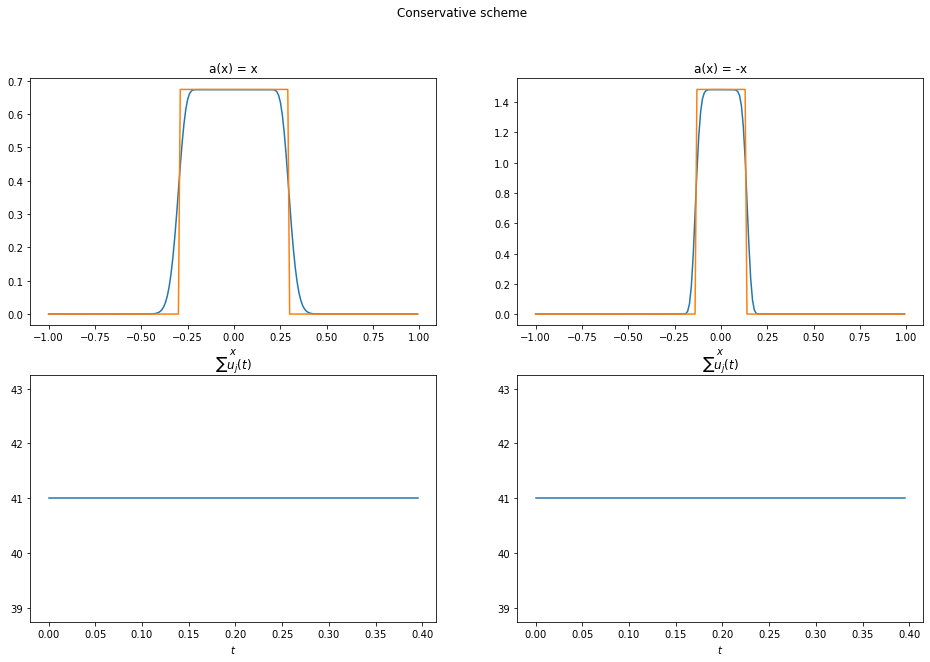

In [13]:
s = simulate()
s.Nx = 200
s.T = 0.4
s.cfl = 0.5
s.method = upwind2
s.probe = np.sum
s.u0 = u0
# plot
fig = plt.figure(figsize=(16,10))
fig.suptitle(f'Conservative scheme')
# iterate for \pm
for k in (1,-1):
    s.a = lambda x:k*x
    s.run()
    s.exact = np.exp(-k*s.t[-1])*s.u0(np.exp(-k*s.t[-1])*s.x)
    sub = fig.add_subplot(2,2,(3-k)//2)
    sub.set_title(f"a(x) = {'-' if k==-1 else ''}x")
    sub.set_xlabel("$x$")
    sub.plot(s.x,s.u)
    sub.plot(s.x,s.exact)
    sub = fig.add_subplot(2,2,2+(3-k)//2)
    sub.set_title(r"$\sum u_j(t)$")
    sub.set_xlabel("$t$")
    sub.plot(s.t,s.probes)
plt.show()

## Convergence order

In [14]:
@np.vectorize
# Compute error for various discretizations
def error_Nx(s,Nx):
    s.Nx = Nx
    s.run()
    s.exact = s.u0(np.exp(-s.t[-1])*s.x)
    return s.error()

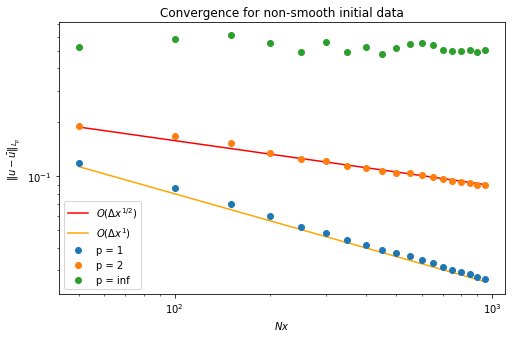

In [15]:
# Compare convergence for various spatial discretizations
s = simulate()
s.T = 0.4
s.method = upwind1
s.u0 = u0
s.a = lambda x:x
# list of discretizations
NN = np.array(range(50,1000,50))
# figure
plt.figure(figsize=(8,5))
plt.title(r"Convergence for non-smooth initial data")
plt.xlabel("$Nx$")
plt.ylabel(r'$\Vert u-\bar{u}\Vert_{L_p}$')
plt.loglog(NN,0.5*NN**-0.25, "r", label=r'$O(\Delta x^{1/2})$')
plt.loglog(NN,0.8*NN**-0.5, "orange", label=r'$O(\Delta x^{1})$')
for p in (1,2,np.inf):
    s.norm = p
    plt.loglog(NN, error_Nx(s,NN), "o", label=f"p = {p}")
plt.legend()
plt.show()

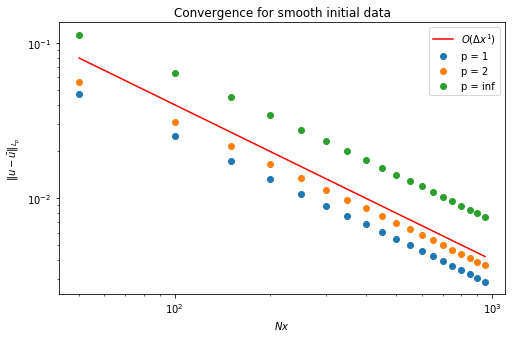

In [16]:
# Compare convergence for various spatial discretizations
s = simulate()
s.T = 0.4
s.method = upwind1
s.u0 = u0_smooth
s.a = lambda x:x
# list of discretizations
NN = np.array(range(50,1000,50))
# figure
plt.figure(figsize=(8,5))
plt.title(r"Convergence for smooth initial data")
plt.xlabel("$Nx$")
plt.ylabel(r'$\Vert u-\bar{u}\Vert_{L_p}$')
plt.loglog(NN,4*NN**-1.0, "r", label=r'$O(\Delta x^{1})$')
for p in (1,2,np.inf):
    s.norm = p
    plt.loglog(NN, error_Nx(s,NN), "o", label=f"p = {p}")
plt.legend()
plt.show()